In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

                                          
商家有时会在特定的日期（如节礼日甩卖、"黑色星期五 "或 "双十一（11月11日）"）
开展大型促销活动（如折扣或现金券），以吸引大量新买家。但是，很多被吸引来的买
家都是一次性的，他们在这次消费之后就再也没有购买，针对这些用户的促销活动并没
有给店铺带来未来销售的增加。为了缓解这个问题，商家必须确定哪些人可以转化为重
复购买者。通过对这些潜在的忠诚客户进行精细化营销，商家可以大大降低促销成本，
提高投资回报率（ROI）。众所周知，在网络广告的领域，用户精准定位具有极大的挑战
性，尤其是对于新买家。不过，借助天猫长期积累的用户行为日志，我们或许可以解决
这个问题。在本次挑战中，我们提供了一组商家以及他们在 "双11 "促销活动中获得的
新买家。你的任务是在给定商家中预测其中哪些新买家会在未来成为忠实客户。换句话
说，你需要预测这些新买家在未来六个月内再次在同一个商家购买商品的概率。我们给
出一个包含约20万用户的数据集进行训练，另一个规模相近的数据集进行测试。


In [2]:
"""
# 加载小样本
user_log = pd.read_csv('./sample_user_log.csv',dtype = {'time_stamp':'str'})
user_info = pd.read_csv('./sample_user_info.csv')
train_data1 = pd.read_csv('./train.csv')
submission = pd.read_csv('./test.csv')
"""

"\n# 加载小样本\nuser_log = pd.read_csv('./sample_user_log.csv',dtype = {'time_stamp':'str'})\nuser_info = pd.read_csv('./sample_user_info.csv')\ntrain_data1 = pd.read_csv('./train.csv')\nsubmission = pd.read_csv('./test.csv')\n"

In [3]:
# 加载全量样本
user_log = pd.read_csv('./user_log_format1.csv',dtype = {'time_stamp':'str'})
user_info = pd.read_csv('./user_info_format1.csv')
train_data1 = pd.read_csv('./train_format1.csv')
submission = pd.read_csv('./test_format1.csv')

In [4]:
#加载含负样本数据
train_data2 = pd.read_csv("./train_format2.csv")

In [5]:
train_data2.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [6]:
print(user_log.shape)
print(user_info.shape)
print(train_data1.shape)
print(submission.shape)

(54925330, 7)
(424170, 3)
(260864, 3)
(261477, 3)


In [7]:
print(train_data1.head())
print(user_log.head())
print(user_info.head())
print(submission.head())

   user_id  merchant_id  label
0    34176         3906      0
1    34176          121      0
2    34176         4356      1
3    34176         2217      0
4   230784         4818      0
   user_id  item_id  cat_id  seller_id  brand_id time_stamp  action_type
0   328862   323294     833       2882    2661.0       0829            0
1   328862   844400    1271       2882    2661.0       0829            0
2   328862   575153    1271       2882    2661.0       0829            0
3   328862   996875    1271       2882    2661.0       0829            0
4   328862  1086186    1271       1253    1049.0       0829            0
   user_id  age_range  gender
0   376517        6.0     1.0
1   234512        5.0     0.0
2   344532        5.0     0.0
3   186135        5.0     0.0
4    30230        5.0     0.0
   user_id  merchant_id  prob
0   163968         4605   NaN
1   360576         1581   NaN
2    98688         1964   NaN
3    98688         3645   NaN
4   295296         3361   NaN


In [8]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([train_data1,submission],ignore_index = True,sort = False)
# print(matrix)
matrix.rename(columns ={'id':'user_id'},inplace = True)
print(matrix.columns.tolist())
print(matrix.shape)

['user_id', 'merchant_id', 'label', 'origin', 'prob']
(522341, 5)


In [9]:
matrix.drop(['prob'],axis = 1,inplace = True)

In [10]:
# 连接user表，通过user_id关联
matrix = matrix.merge(user_info,on = 'user_id',how = 'left')

In [11]:
# 使用merchant_id,原列名seller_id
user_log.rename(columns = {'seller_id' : 'merchant_id'},inplace = True)

In [12]:
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['brand_id'].fillna(0,inplace = True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'],format = '%H%M')
# 1 for < 18;2 for [18,24];3 for [25,29];4 for [30,34];5 for [34,39];6 for [40,49];7 and 8 for >= 50;0 for unknown and NULL
matrix['age_range'].fillna(0,inplace = True)
# 0:female;1:male;2:unknown
matrix['gender'].fillna(2,inplace = True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del user_info, train_data1
gc.collect()
print(matrix)

        user_id  merchant_id label origin  age_range  gender
0         34176         3906   0.0  train          6       0
1         34176          121   0.0  train          6       0
2         34176         4356   1.0  train          6       0
3         34176         2217   0.0  train          6       0
4        230784         4818   0.0  train          0       0
...         ...          ...   ...    ...        ...     ...
522336   228479         3111   nan   test          6       0
522337    97919         2341   nan   test          8       1
522338    97919         3971   nan   test          8       1
522339    32639         3536   nan   test          0       0
522340    32639         3319   nan   test          0       0

[522341 rows x 6 columns]


In [13]:
# user特征处理
groups = user_log.groupby(['user_id'])
# 用户交互行为数量u1
temp = groups.size().reset_index().rename(columns = {0 : 'u1'})
matrix = matrix.merge(temp,on = 'user_id',how = 'left')
# 使用agg基于列的操作，统计唯一值的个数item_id,cat_id,merchant_id,brand_id
temp = groups['item_id'].agg([('u2','nunique')]).reset_index()
matrix = matrix.merge(temp,on = 'user_id',how = 'left')
temp = groups['cat_id'].agg([('u3','nunique')]).reset_index()
matrix = matrix.merge(temp,on = 'user_id',how = 'left')
temp = groups['merchant_id'].agg([('u4','nunique')]).reset_index()
matrix = matrix.merge(temp,on = 'user_id',how = 'left')
temp = groups['brand_id'].agg([('u5','nunique')]).reset_index()
matrix = matrix.merge(temp,on = 'user_id',how = 'left')

In [14]:
# 时间间隔特征u6,按照小时
temp = groups['time_stamp'].agg([('F_time','min'),('L_time','max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id','u6']],on = 'user_id',how = 'left')

In [15]:
# 统计操作类型为0:点击，1：加购，2：购买，3：收藏的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns = {0:'u7',1:'u8',2:'u9',3:'u10'})
matrix = matrix.merge(temp,on = 'user_id',how = 'left')
# print(matrix)

In [16]:
#每个用户购买行为数量
temp = user_log[user_log["action_type"] == 2].groupby(["user_id"])["action_type"].agg([("u11","nunique")]).reset_index()
matrix = matrix.merge(temp, on="user_id", how ="left")
#每个用户购买商家数量
temp = user_log[user_log["action_type"] == 2].groupby(["user_id"])["merchant_id"].agg([("u12", "nunique")]).reset_index()
matrix = matrix.merge(temp, on="user_id", how="left")
#用户购买时间间隔
temp = user_log[user_log["action_type"] ==2].groupby(["user_id"])["time_stamp"].agg([("F_time","min"),("L_time","max")]).reset_index()
temp["u13"] =(temp["L_time"] - temp["F_time"]).dt.seconds/3600
matrix = matrix.merge(temp[["user_id","u13"]], on="user_id", how="left")

In [17]:
# 商家特征处理
groups = user_log.groupby(['merchant_id'])
# 商家被交互数量 m1
temp = groups.size().reset_index().rename(columns = {0:'m1'})
matrix = matrix.merge(temp,on = 'merchant_id',how = 'left')
# 统计商家被交互的user_id,item_id,cat_id,brand_id的唯一值
temp = groups['user_id','item_id','cat_id','brand_id'].nunique().reset_index().rename(       
    columns = {'user_id':'m2','item_id':'m3','cat_id':'m4','brand_id':'m5'})
matrix = matrix.merge(temp,on = 'merchant_id',how = 'left')
# 统计商家被交互的action_type唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns = {0:'m6',1:'m7',2:'m8',3:'m9'})
matrix = matrix.merge(temp,on = 'merchant_id',how = 'left')
# 按照merchant_id统计随机负采样个数
temp = train_data2[train_data2['label'] == -1].groupby(['merchant_id']).size().reset_index().rename(columns = {0:'m10'})
matrix = matrix.merge(temp,on = 'merchant_id',how = 'left')
del train_data2
gc.collect()
# print(matrix)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


0

In [18]:
#商家产生购买行为的数量
temp = user_log[user_log["action_type"]==2].groupby(["merchant_id"])["action_type"].agg([("m11", "nunique")]).reset_index()
matrix = matrix.merge(temp, on="merchant_id", how="left")
#商家产生购买行为用户数量
temp = user_log[user_log["action_type"]==2].groupby(["merchant_id"])["user_id"].agg([("m12", "nunique")]).reset_index()
matrix = matrix.merge(temp, on="merchant_id", how="left")
#商家购买间隔
temp = user_log[user_log["action_type"]==2].groupby(["merchant_id"])["time_stamp"].agg([("F_time","min"),("L_time","max")]).reset_index()
temp["m13"] = (temp["L_time"] -temp["F_time"]).dt.seconds/3600
matrix = matrix.merge(temp[["merchant_id","m13"]], on="merchant_id", how="left")

In [19]:
# 按照user_id,merchant_id分组
groups = user_log.groupby(['user_id','merchant_id'])
# 统计行为个数
temp = groups.size().reset_index().rename(columns = {0:'um1'})
matrix = matrix.merge(temp,on = ['user_id','merchant_id'],how = 'left')
# 统计item_id,cat_id,brand_id唯一的个数
temp = groups['item_id','cat_id','brand_id'].nunique().reset_index().rename(columns = {'item_id':'um2','cat_id':'um3','brand_id':'um4'})
matrix = matrix.merge(temp,on = ['user_id','merchant_id'],how = 'left')
# 统计不同action_type的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns = {0:'um5',1:'um6',2:'um7',3:'um8'})
matrix = matrix.merge(temp,on = ['user_id','merchant_id'],how = 'left')
# 统计时间间隔
temp = groups['time_stamp'].agg([('first','min'),('last','max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['first','last'],axis = 1,inplace =True)
matrix = matrix.merge(temp,on = ['user_id','merchant_id'],how = 'left')
# print(matrix)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [20]:
#用户-商家购买间隔
groups = user_log[user_log["action_type"]==2].groupby(["user_id","merchant_id"])
temp = groups["time_stamp"].agg([("F_time","min"),("L_time","max")]).reset_index()
temp["um10"] = (temp["L_time"]-temp["F_time"]).dt.seconds/3600
matrix = matrix.merge(temp[["user_id","merchant_id","um10"]], on=["user_id","merchant_id"], how="left")

In [21]:
# 用户购买点击比
matrix['r1'] = matrix['u9'] / matrix['u7']
# 商家购买点击比
matrix['r2'] = matrix['m8'] / matrix['m6']
# 不同用户不同商家购买点击比
matrix['r3'] = matrix['um7'] / matrix['um5']
#用户重复购买率
matrix["r4"] = (matrix["u11"] - matrix["u12"]) / matrix["u11"]
#用户购买频率
matrix["r5"] = matrix["u11"] / matrix["u13"]
#商家重复购买率
matrix["r6"] = (matrix["m11"] - matrix["m12"]) / matrix["m11"]
#商家购买频率
matrix["r7"] = matrix["m11"] / matrix["m13"]
#用户-商家购买频率
matrix["r8"] = matrix["um7"] / matrix["um10"]
matrix.fillna(0,inplace = True)

In [22]:
# age_range,gender字段做one_hot处理
temp = pd.get_dummies(matrix['age_range'],prefix = 'age')
matrix = pd.concat([matrix,temp],axis = 1)
temp = pd.get_dummies(matrix['gender'],prefix = 'g')
matrix = pd.concat([matrix,temp],axis = 1)
matrix.drop(['age_range','gender'],axis = 1,inplace = True)
print(matrix)

        user_id  merchant_id label origin    u1    u2  u3   u4   u5        u6  \
0         34176         3906   0.0  train   451   256  45  109  108  5.833333   
1         34176          121   0.0  train   451   256  45  109  108  5.833333   
2         34176         4356   1.0  train   451   256  45  109  108  5.833333   
3         34176         2217   0.0  train   451   256  45  109  108  5.833333   
4        230784         4818   0.0  train    54    31  17   20   19  5.166667   
...         ...          ...   ...    ...   ...   ...  ..  ...  ...       ...   
522336   228479         3111   nan   test  2004  1173  71  278  282  6.000000   
522337    97919         2341   nan   test    55    29  14   17   17  4.750000   
522338    97919         3971   nan   test    55    29  14   17   17  4.750000   
522339    32639         3536   nan   test    72    46  24   33   35  5.800000   
522340    32639         3319   nan   test    72    46  24   33   35  5.800000   

        ...  age_2  age_3  

In [23]:
# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'],axis = 1)
test_data = matrix[matrix['origin'] == 'test'].drop(['origin','label'],axis = 1)
train_X,train_y = train_data.drop(['label'],axis =1),train_data['label']
# del temp,matrix
# gc.collect()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


0.0    244912
1.0     15952
Name: label, dtype: int64


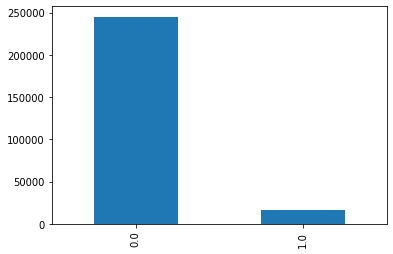

In [24]:
train_y.value_counts().plot(kind = "bar")
print(train_y.value_counts())

In [25]:
from sklearn.model_selection import train_test_split

# 将训练集进行切分，20%用于验证
X_train,X_valid,y_train,y_valid = train_test_split(train_X, train_y, test_size = 0.2,random_state = 33)

In [26]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import cross_val_score
import xgboost as xgb

#目标函数
def objective(params):
    model = xgb.XGBClassifier(**params)     
    result = cross_val_score(model, X_train, y_train, cv=5, scoring = "roc_auc").mean()
    return -result  

#搜索空间
space = {"max_depth": hp.choice("max_depth", range(5,15)),
         "n_estimators": hp.choice("n_estimators", range(100,3000)),
         "learning_rate": hp.choice("learning_rate", [0.001, 0.005,0.008,0.01,0.02,0.05,0.08,0.1]),
         "min_child_weight": hp.choice("min_child_weight", range(5,500)),
         "colsample_bytree": hp.choice("colsample_bytree", [0.5,0.6,0.7,0.8,0.9, 1]),
         "subsample": hp.choice("subsample", [0.5, 0.6,0.7,0.8,0.9,1]),
         }

# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals = 30)

# best_params = space_eval(space,best)
# print(best_params)

In [27]:
# 使用XGBoost
model = xgb.XGBClassifier(max_depth = 14,
                         n_estimators = 10000,
                         min_child_weight = 188,
                         colsample_bytree = 0.8,
                         subsample = 0.9,
                         learning_rate = 0.01,                         
                         seed = 42)

model.fit(X_train,y_train,
         eval_metric = 'auc',
         eval_set = [(X_train,y_train),(X_valid,y_valid)],
         verbose = True,
         early_stopping_rounds = 100)

[0]	validation_0-auc:0.64283	validation_1-auc:0.63338
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.65277	validation_1-auc:0.63920
[2]	validation_0-auc:0.65952	validation_1-auc:0.64353
[3]	validation_0-auc:0.66319	validation_1-auc:0.64554
[4]	validation_0-auc:0.66482	validation_1-auc:0.64720
[5]	validation_0-auc:0.66526	validation_1-auc:0.64780
[6]	validation_0-auc:0.66696	validation_1-auc:0.64812
[7]	validation_0-auc:0.66710	validation_1-auc:0.64823
[8]	validation_0-auc:0.66737	validation_1-auc:0.64882
[9]	validation_0-auc:0.66916	validation_1-auc:0.64983
[10]	validation_0-auc:0.67086	validation_1-auc:0.65215
[11]	validation_0-auc:0.67087	validation_1-auc:0.65176
[12]	validation_0-auc:0.67066	validation_1-auc:0.65168
[13]	validation_0-auc:0.67070	validation_1-auc:0.65161
[14]	validation_0-auc:0.67039	validation_1-auc:0.65145
[15]	validation_0-auc:0.670

[146]	validation_0-auc:0.69925	validation_1-auc:0.65874
[147]	validation_0-auc:0.69928	validation_1-auc:0.65880
[148]	validation_0-auc:0.69940	validation_1-auc:0.65894
[149]	validation_0-auc:0.69938	validation_1-auc:0.65892
[150]	validation_0-auc:0.69945	validation_1-auc:0.65887
[151]	validation_0-auc:0.69943	validation_1-auc:0.65887
[152]	validation_0-auc:0.69939	validation_1-auc:0.65881
[153]	validation_0-auc:0.69944	validation_1-auc:0.65892
[154]	validation_0-auc:0.69947	validation_1-auc:0.65898
[155]	validation_0-auc:0.69943	validation_1-auc:0.65896
[156]	validation_0-auc:0.69941	validation_1-auc:0.65892
[157]	validation_0-auc:0.69949	validation_1-auc:0.65900
[158]	validation_0-auc:0.69955	validation_1-auc:0.65908
[159]	validation_0-auc:0.69955	validation_1-auc:0.65904
[160]	validation_0-auc:0.69952	validation_1-auc:0.65904
[161]	validation_0-auc:0.69955	validation_1-auc:0.65906
[162]	validation_0-auc:0.69955	validation_1-auc:0.65902
[163]	validation_0-auc:0.69957	validation_1-auc:

[293]	validation_0-auc:0.70213	validation_1-auc:0.66054
[294]	validation_0-auc:0.70218	validation_1-auc:0.66061
[295]	validation_0-auc:0.70227	validation_1-auc:0.66063
[296]	validation_0-auc:0.70224	validation_1-auc:0.66060
[297]	validation_0-auc:0.70227	validation_1-auc:0.66062
[298]	validation_0-auc:0.70235	validation_1-auc:0.66074
[299]	validation_0-auc:0.70244	validation_1-auc:0.66084
[300]	validation_0-auc:0.70245	validation_1-auc:0.66086
[301]	validation_0-auc:0.70250	validation_1-auc:0.66088
[302]	validation_0-auc:0.70252	validation_1-auc:0.66088
[303]	validation_0-auc:0.70254	validation_1-auc:0.66090
[304]	validation_0-auc:0.70257	validation_1-auc:0.66095
[305]	validation_0-auc:0.70259	validation_1-auc:0.66097
[306]	validation_0-auc:0.70269	validation_1-auc:0.66102
[307]	validation_0-auc:0.70271	validation_1-auc:0.66103
[308]	validation_0-auc:0.70279	validation_1-auc:0.66114
[309]	validation_0-auc:0.70281	validation_1-auc:0.66115
[310]	validation_0-auc:0.70290	validation_1-auc:

[440]	validation_0-auc:0.71176	validation_1-auc:0.66783
[441]	validation_0-auc:0.71184	validation_1-auc:0.66788
[442]	validation_0-auc:0.71194	validation_1-auc:0.66796
[443]	validation_0-auc:0.71201	validation_1-auc:0.66798
[444]	validation_0-auc:0.71207	validation_1-auc:0.66799
[445]	validation_0-auc:0.71215	validation_1-auc:0.66803
[446]	validation_0-auc:0.71223	validation_1-auc:0.66806
[447]	validation_0-auc:0.71233	validation_1-auc:0.66811
[448]	validation_0-auc:0.71237	validation_1-auc:0.66810
[449]	validation_0-auc:0.71244	validation_1-auc:0.66813
[450]	validation_0-auc:0.71251	validation_1-auc:0.66817
[451]	validation_0-auc:0.71256	validation_1-auc:0.66822
[452]	validation_0-auc:0.71264	validation_1-auc:0.66831
[453]	validation_0-auc:0.71271	validation_1-auc:0.66837
[454]	validation_0-auc:0.71281	validation_1-auc:0.66849
[455]	validation_0-auc:0.71289	validation_1-auc:0.66860
[456]	validation_0-auc:0.71297	validation_1-auc:0.66865
[457]	validation_0-auc:0.71303	validation_1-auc:

[587]	validation_0-auc:0.72282	validation_1-auc:0.67405
[588]	validation_0-auc:0.72285	validation_1-auc:0.67405
[589]	validation_0-auc:0.72292	validation_1-auc:0.67404
[590]	validation_0-auc:0.72296	validation_1-auc:0.67405
[591]	validation_0-auc:0.72303	validation_1-auc:0.67407
[592]	validation_0-auc:0.72311	validation_1-auc:0.67408
[593]	validation_0-auc:0.72318	validation_1-auc:0.67413
[594]	validation_0-auc:0.72326	validation_1-auc:0.67417
[595]	validation_0-auc:0.72333	validation_1-auc:0.67420
[596]	validation_0-auc:0.72341	validation_1-auc:0.67423
[597]	validation_0-auc:0.72347	validation_1-auc:0.67424
[598]	validation_0-auc:0.72354	validation_1-auc:0.67426
[599]	validation_0-auc:0.72361	validation_1-auc:0.67427
[600]	validation_0-auc:0.72366	validation_1-auc:0.67430
[601]	validation_0-auc:0.72374	validation_1-auc:0.67431
[602]	validation_0-auc:0.72380	validation_1-auc:0.67432
[603]	validation_0-auc:0.72386	validation_1-auc:0.67435
[604]	validation_0-auc:0.72394	validation_1-auc:

[734]	validation_0-auc:0.73164	validation_1-auc:0.67748
[735]	validation_0-auc:0.73172	validation_1-auc:0.67748
[736]	validation_0-auc:0.73178	validation_1-auc:0.67752
[737]	validation_0-auc:0.73184	validation_1-auc:0.67752
[738]	validation_0-auc:0.73191	validation_1-auc:0.67753
[739]	validation_0-auc:0.73195	validation_1-auc:0.67758
[740]	validation_0-auc:0.73201	validation_1-auc:0.67760
[741]	validation_0-auc:0.73206	validation_1-auc:0.67761
[742]	validation_0-auc:0.73211	validation_1-auc:0.67763
[743]	validation_0-auc:0.73218	validation_1-auc:0.67761
[744]	validation_0-auc:0.73224	validation_1-auc:0.67761
[745]	validation_0-auc:0.73231	validation_1-auc:0.67763
[746]	validation_0-auc:0.73234	validation_1-auc:0.67765
[747]	validation_0-auc:0.73241	validation_1-auc:0.67766
[748]	validation_0-auc:0.73246	validation_1-auc:0.67771
[749]	validation_0-auc:0.73252	validation_1-auc:0.67773
[750]	validation_0-auc:0.73257	validation_1-auc:0.67776
[751]	validation_0-auc:0.73262	validation_1-auc:

[881]	validation_0-auc:0.73914	validation_1-auc:0.67951
[882]	validation_0-auc:0.73921	validation_1-auc:0.67951
[883]	validation_0-auc:0.73922	validation_1-auc:0.67952
[884]	validation_0-auc:0.73925	validation_1-auc:0.67954
[885]	validation_0-auc:0.73931	validation_1-auc:0.67953
[886]	validation_0-auc:0.73935	validation_1-auc:0.67954
[887]	validation_0-auc:0.73942	validation_1-auc:0.67953
[888]	validation_0-auc:0.73946	validation_1-auc:0.67954
[889]	validation_0-auc:0.73952	validation_1-auc:0.67954
[890]	validation_0-auc:0.73957	validation_1-auc:0.67955
[891]	validation_0-auc:0.73962	validation_1-auc:0.67957
[892]	validation_0-auc:0.73965	validation_1-auc:0.67958
[893]	validation_0-auc:0.73967	validation_1-auc:0.67958
[894]	validation_0-auc:0.73970	validation_1-auc:0.67960
[895]	validation_0-auc:0.73973	validation_1-auc:0.67962
[896]	validation_0-auc:0.73976	validation_1-auc:0.67961
[897]	validation_0-auc:0.73981	validation_1-auc:0.67962
[898]	validation_0-auc:0.73986	validation_1-auc:

[1027]	validation_0-auc:0.74557	validation_1-auc:0.68066
[1028]	validation_0-auc:0.74561	validation_1-auc:0.68066
[1029]	validation_0-auc:0.74563	validation_1-auc:0.68067
[1030]	validation_0-auc:0.74566	validation_1-auc:0.68068
[1031]	validation_0-auc:0.74569	validation_1-auc:0.68067
[1032]	validation_0-auc:0.74574	validation_1-auc:0.68065
[1033]	validation_0-auc:0.74579	validation_1-auc:0.68064
[1034]	validation_0-auc:0.74584	validation_1-auc:0.68064
[1035]	validation_0-auc:0.74590	validation_1-auc:0.68064
[1036]	validation_0-auc:0.74593	validation_1-auc:0.68066
[1037]	validation_0-auc:0.74600	validation_1-auc:0.68067
[1038]	validation_0-auc:0.74603	validation_1-auc:0.68067
[1039]	validation_0-auc:0.74609	validation_1-auc:0.68065
[1040]	validation_0-auc:0.74614	validation_1-auc:0.68065
[1041]	validation_0-auc:0.74616	validation_1-auc:0.68065
[1042]	validation_0-auc:0.74621	validation_1-auc:0.68067
[1043]	validation_0-auc:0.74625	validation_1-auc:0.68066
[1044]	validation_0-auc:0.74627

[1171]	validation_0-auc:0.75150	validation_1-auc:0.68144
[1172]	validation_0-auc:0.75153	validation_1-auc:0.68144
[1173]	validation_0-auc:0.75155	validation_1-auc:0.68146
[1174]	validation_0-auc:0.75160	validation_1-auc:0.68147
[1175]	validation_0-auc:0.75165	validation_1-auc:0.68146
[1176]	validation_0-auc:0.75170	validation_1-auc:0.68148
[1177]	validation_0-auc:0.75173	validation_1-auc:0.68150
[1178]	validation_0-auc:0.75174	validation_1-auc:0.68150
[1179]	validation_0-auc:0.75176	validation_1-auc:0.68151
[1180]	validation_0-auc:0.75180	validation_1-auc:0.68151
[1181]	validation_0-auc:0.75185	validation_1-auc:0.68150
[1182]	validation_0-auc:0.75191	validation_1-auc:0.68151
[1183]	validation_0-auc:0.75195	validation_1-auc:0.68153
[1184]	validation_0-auc:0.75198	validation_1-auc:0.68152
[1185]	validation_0-auc:0.75203	validation_1-auc:0.68153
[1186]	validation_0-auc:0.75206	validation_1-auc:0.68154
[1187]	validation_0-auc:0.75208	validation_1-auc:0.68154
[1188]	validation_0-auc:0.75214

[1315]	validation_0-auc:0.75665	validation_1-auc:0.68204
[1316]	validation_0-auc:0.75666	validation_1-auc:0.68204
[1317]	validation_0-auc:0.75669	validation_1-auc:0.68203
[1318]	validation_0-auc:0.75673	validation_1-auc:0.68202
[1319]	validation_0-auc:0.75678	validation_1-auc:0.68200
[1320]	validation_0-auc:0.75682	validation_1-auc:0.68201
[1321]	validation_0-auc:0.75687	validation_1-auc:0.68200
[1322]	validation_0-auc:0.75690	validation_1-auc:0.68199
[1323]	validation_0-auc:0.75693	validation_1-auc:0.68198
[1324]	validation_0-auc:0.75695	validation_1-auc:0.68199
[1325]	validation_0-auc:0.75699	validation_1-auc:0.68198
[1326]	validation_0-auc:0.75704	validation_1-auc:0.68199
[1327]	validation_0-auc:0.75708	validation_1-auc:0.68201
[1328]	validation_0-auc:0.75713	validation_1-auc:0.68200
[1329]	validation_0-auc:0.75717	validation_1-auc:0.68200
[1330]	validation_0-auc:0.75722	validation_1-auc:0.68200
[1331]	validation_0-auc:0.75725	validation_1-auc:0.68200
[1332]	validation_0-auc:0.75729

[1459]	validation_0-auc:0.76148	validation_1-auc:0.68228
[1460]	validation_0-auc:0.76148	validation_1-auc:0.68228
[1461]	validation_0-auc:0.76150	validation_1-auc:0.68229
[1462]	validation_0-auc:0.76151	validation_1-auc:0.68230
[1463]	validation_0-auc:0.76153	validation_1-auc:0.68231
[1464]	validation_0-auc:0.76155	validation_1-auc:0.68230
[1465]	validation_0-auc:0.76162	validation_1-auc:0.68232
[1466]	validation_0-auc:0.76165	validation_1-auc:0.68231
[1467]	validation_0-auc:0.76169	validation_1-auc:0.68230
[1468]	validation_0-auc:0.76174	validation_1-auc:0.68231
[1469]	validation_0-auc:0.76176	validation_1-auc:0.68233
[1470]	validation_0-auc:0.76177	validation_1-auc:0.68231
[1471]	validation_0-auc:0.76180	validation_1-auc:0.68232
[1472]	validation_0-auc:0.76184	validation_1-auc:0.68232
[1473]	validation_0-auc:0.76185	validation_1-auc:0.68233
[1474]	validation_0-auc:0.76186	validation_1-auc:0.68233
[1475]	validation_0-auc:0.76189	validation_1-auc:0.68233
[1476]	validation_0-auc:0.76196

[1603]	validation_0-auc:0.76618	validation_1-auc:0.68262
[1604]	validation_0-auc:0.76622	validation_1-auc:0.68262
[1605]	validation_0-auc:0.76627	validation_1-auc:0.68262
[1606]	validation_0-auc:0.76630	validation_1-auc:0.68261
[1607]	validation_0-auc:0.76634	validation_1-auc:0.68262
[1608]	validation_0-auc:0.76636	validation_1-auc:0.68263
[1609]	validation_0-auc:0.76638	validation_1-auc:0.68263
[1610]	validation_0-auc:0.76640	validation_1-auc:0.68264
[1611]	validation_0-auc:0.76645	validation_1-auc:0.68264
[1612]	validation_0-auc:0.76648	validation_1-auc:0.68264
[1613]	validation_0-auc:0.76650	validation_1-auc:0.68263
[1614]	validation_0-auc:0.76653	validation_1-auc:0.68263
[1615]	validation_0-auc:0.76654	validation_1-auc:0.68264
[1616]	validation_0-auc:0.76658	validation_1-auc:0.68264
[1617]	validation_0-auc:0.76660	validation_1-auc:0.68266
[1618]	validation_0-auc:0.76663	validation_1-auc:0.68267
[1619]	validation_0-auc:0.76664	validation_1-auc:0.68268
[1620]	validation_0-auc:0.76666

[1747]	validation_0-auc:0.77062	validation_1-auc:0.68276
[1748]	validation_0-auc:0.77063	validation_1-auc:0.68277
[1749]	validation_0-auc:0.77064	validation_1-auc:0.68277
[1750]	validation_0-auc:0.77066	validation_1-auc:0.68278
[1751]	validation_0-auc:0.77070	validation_1-auc:0.68278
[1752]	validation_0-auc:0.77075	validation_1-auc:0.68279
[1753]	validation_0-auc:0.77078	validation_1-auc:0.68278
[1754]	validation_0-auc:0.77080	validation_1-auc:0.68280
[1755]	validation_0-auc:0.77085	validation_1-auc:0.68277
[1756]	validation_0-auc:0.77089	validation_1-auc:0.68277
[1757]	validation_0-auc:0.77094	validation_1-auc:0.68275
[1758]	validation_0-auc:0.77097	validation_1-auc:0.68275
[1759]	validation_0-auc:0.77099	validation_1-auc:0.68276
[1760]	validation_0-auc:0.77103	validation_1-auc:0.68275
[1761]	validation_0-auc:0.77107	validation_1-auc:0.68274
[1762]	validation_0-auc:0.77109	validation_1-auc:0.68272
[1763]	validation_0-auc:0.77110	validation_1-auc:0.68273
[1764]	validation_0-auc:0.77112

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=14,
              min_child_weight=188, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
#xgboost预测
xgb_prob = model.predict_proba(test_data)
xgb_prob = pd.Series(xgb_prob[:,1])

In [29]:
#deepFM
from sklearn.preprocessing import LabelEncoder,StandardScaler
from deepctr.feature_column import SparseFeat,VarLenSparseFeat,DenseFeat,get_feature_names
from deepctr.models import DeepFM


data = matrix.copy()
sparse_features = train_X.columns.tolist()
# print(sparse_features)
# target = ["label"]

#对特征标签进行编码
for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])

#计算每个特征中不同特征取值的个数
fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique()) for feature in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 60 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      522341 non-null  int64 
 1   merchant_id  522341 non-null  int64 
 2   label        522341 non-null  object
 3   origin       522341 non-null  object
 4   u1           522341 non-null  int64 
 5   u2           522341 non-null  int64 
 6   u3           522341 non-null  int64 
 7   u4           522341 non-null  int64 
 8   u5           522341 non-null  int64 
 9   u6           522341 non-null  int64 
 10  u7           522341 non-null  int64 
 11  u8           522341 non-null  int64 
 12  u9           522341 non-null  int64 
 13  u10          522341 non-null  int64 
 14  u11          522341 non-null  int64 
 15  u12          522341 non-null  int64 
 16  u13          522341 non-null  int64 
 17  m1           522341 non-null  int64 
 18  m2           522341 non-null  int64 
 19  m3

In [31]:
#将数据集切分成训练集和测试集
train_data = data[data['origin'] == 'train'].drop(['origin'],axis = 1)
test_data = data[data['origin'] == 'test'].drop(['origin','label'],axis = 1)
#构造模型输入数据
train_model_input = {name:train_data[name].values for name in feature_names}
test_model_input = {name:test_data[name].values for name in feature_names}

In [32]:
#使用DeepFM进行训练
model = DeepFM(linear_feature_columns, dnn_feature_columns)
model.compile("adam","binary_crossentropy", metrics=["AUC"])
history = model.fit(train_model_input, train_data["label"].astype("float").values, batch_size=256, epochs=1, verbose=True, validation_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
816/816 [==============================] - 78s 96ms/step - loss: 0.2268 - auc: 0.6532 - val_loss: 0.2205 - val_auc: 0.6796


In [33]:
#使用DeepFM进行预测
deepfm_prob = model.predict(test_model_input, batch_size=256)
deepfm_prob = pd.Series(deepfm_prob[:,0])
# submission['prob'] = (submission['prob'] + deepfm_prob) /2
# submission.to_csv('prediction.csv',index = False)

In [34]:
# 使用DIN模型
from deepctr.models import DIN

In [35]:
lbe_action_type = {0:1,1:2,2:3,3:4}
user_log["action_type"] = user_log["action_type"].map(lbe_action_type)

In [36]:
#用户行为sequence
temp = pd.DataFrame(user_log.groupby("user_id")["merchant_id","action_type"].agg(lambda x:list(x)))
#列名改为hist_merchant_id,hist_action_type
temp.columns = ["hist_merchant_id","hist_action_type"]
matrix = matrix.merge(temp, on=["user_id"], how="left")
matrix["action_type"] = 3
# print(matrix.info())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [44]:
#补全,截取定长M个
merchant_lens = max([len(x) for x in matrix["hist_merchant_id"]])
# print(merchant_lens)
action_type_lens = max([len(x) for x in matrix["hist_action_type"]])
M = 500
matrix["hist_merchant_id"] = matrix["hist_merchant_id"].apply(lambda x: np.array([0]*(merchant_lens - len(x)) + x)[-M:])
matrix["hist_action_type"] = matrix["hist_action_type"].apply(lambda x: np.array([0]*(action_type_lens - len(x)) + x)[-M:])    

In [45]:
#制作feature_columns
sparse_features = matrix.columns.tolist()
sparse_features.remove("origin")
sparse_features.remove("label")
feature_columns = []
for column in sparse_features:
    if column == "hist_merchant_id":
        feature_columns +=[VarLenSparseFeat(SparseFeat("hist_merchant_id",vocabulary_size=4995+1,
                                               embedding_name="merchant_id"),maxlen=M)]
    elif column == "merchant_id":
        feature_columns +=[SparseFeat(column,4995+1)]
    elif column == "hist_action_type":
        feature_columns +=[VarLenSparseFeat(SparseFeat("hist_action_type",vocabulary_size=4+1,
                                               embedding_name="action_type"),maxlen=M)]
    elif column == "action_type":
        feature_columns += [SparseFeat(column,4+1)]
    else:
        matrix[column] = lbe.fit_transform(matrix[column])
        feature_columns += [SparseFeat(column,matrix[column].nunique())]
# print(feature_columns)        

In [46]:
#分割训练数据和测试数据
train_data = matrix[matrix["origin"] == "train"].drop(["origin"],axis =1)
test_data = matrix[matrix["origin"] == "test"].drop(["origin","label"],axis =1)
train_X, train_y = train_data.drop(["label"], axis=1), train_data["label"].apply(lambda x:int(float(x)))
print(train_X.head())
print(train_X.columns)

   user_id  merchant_id   u1   u2  u3   u4   u5   u6   u7  u8  ...  age_5  \
0    34175         3906  449  255  44  108  107  174  410   0  ...      0   
1    34175          121  449  255  44  108  107  174  410   0  ...      0   
2    34175         4356  449  255  44  108  107  174  410   0  ...      0   
3    34175         2217  449  255  44  108  107  174  410   0  ...      0   
4   230783         4818   52   30  16   19   18  162   47   0  ...      0   

   age_6  age_7  age_8  g_0  g_1  g_2  \
0      1      0      0    1    0    0   
1      1      0      0    1    0    0   
2      1      0      0    1    0    0   
3      1      0      0    1    0    0   
4      0      0      0    1    0    0   

                                    hist_merchant_id  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 

In [47]:
#设置行为特征
behavior_features=["merchan_id","action_type"]

In [48]:
#DIN模型
model = DIN(feature_columns,behavior_features)
model.compile("adam","binary_crossentropy",metrics=["AUC"])
feature_names = list(train_X.columns)
train_model_input = {name:train_X[name].values for name in feature_names}

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_1/local_activation_unit_1/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_1/local_activation_unit_1/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [49]:
#hist特征输入要求为二维数组
from tqdm import tqdm
for fea in ["hist_merchant_id","hist_action_type"]:
    temp = []
    for i in tqdm(train_model_input[fea]):
        temp.append(i)
    train_model_input[fea] = np.array(temp)
# print(train_model_input["hist_merchant_id"])

100%|██████████| 260864/260864 [00:00<00:00, 2364329.05it/s]


In [50]:
#模型训练
history = model.fit(train_model_input,train_y,verbose=True,epochs=1,validation_split=0.2,batch_size=256)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


816/816 [==============================] - 263s 322ms/step - loss: 0.2283 - auc: 0.6517 - val_loss: 0.2202 - val_auc: 0.6779


In [51]:
#转换test_model_input,模型要求输入为二维数组
test_model_input = {name: test_data[name].values for name in feature_names}
for fea in ["hist_merchant_id", "hist_action_type"]:
    temp = []
    for i in test_model_input[fea]:
        temp.append(i)
    test_model_input[fea] = np.array(temp)    

In [52]:
din_prob = model.predict(test_model_input, batch_size=256)
# print(din_prob)
din_prob = pd.Series(din_prob[:,0])
submission['prob'] = (din_prob + deepfm_prob + xgb_prob)/ 3
submission.drop(['origin'],axis = 1,inplace = True)
submission.to_csv('prediction.csv',index = False)